<a href="https://colab.research.google.com/github/minkyeongk/Deep_Learning_Specialization/blob/main/1.%20Neural%20Network%20and%20Deep%20Learning/week%202.%20Neural%20Networks%20Basics/%20week_2_Logistic_Regression_with_a_Neural_Network_mindset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression with a Neural Network mindset

명시되어 있지 않은 경우 loop 사용 금지 


learning algorithm의 일반적인 구조 생성  
> 패러미터 초기화 

> cost function과 함수의 gradient 계산 (forward and back propagation)

> 최적화 알고리즘 적용 (gradient descent)

In [10]:
# tmp에 저장해서 사용하면 필요 없음 
#from google.colab import drive 
#drive.mount('/content/gdrive')

In [11]:
import numpy as np                # 행렬, 과학적 계산 
import matplotlib.pyplot as plt   # plot graph
import h5py                       # h5 파일로 저장된 데이터셋
import scipy                      # 수학 라이브러리, 자체 테스트에 사용
from PIL import Image           # 이미지 라이브러리 
from scipy import ndimage

#from lr_utils import load_dataset
def load_dataset():
    # 자체 모듈은 함수 자체를 이렇게 옮겨와서 사용 
    # 데이터는 tmp에 저장해 사용 
    train_dataset = h5py.File('/tmp/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/tmp/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

% matplotlib inline 

In [12]:
# 고양이(1)/ 고양이가 아닌것(0) 
# shape = (num_px, num_px, 3)
# height, width, color channel(3, RGB), 가로 세로 사이즈 동일  

# 데이터 불러오기 
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y=[1], its a 'cat' picture.


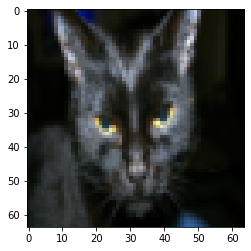

In [13]:
index = 25
plt.imshow(train_set_x_orig[index])
#print(train_set_y.shape)    # train sets 각 데이터의 레이블 
#print(np.squeeze(train_set_y[:, index]))    # squeeze 1차원인 축을 제거, 여기서는 괄호 벗기는 용도 정도 
print("y=" + str(train_set_y[:,index]) + ", its a '"+ classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture." )
# [:, a]는 a번째 열을 나타냄 

In [14]:
# 많은 버그는 매트릭스 dimension이 fit 하지 않아 발생 
m_train = train_set_y.shape[1]    # shape 함수 
#print(train_set_y)   #(1, 209), [[데이터 209개]]의 형태 
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]
#print(train_set_x_orig.shape)  #(이미지 개수, num_px, num_px, RGB)

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [15]:
# reshape images > (이미지 개수, num_px, num_px, 3) to (num_px * num_px * 3, 이미지 개수)
# 각 열, column이 flatten된 이미지, 이미지를 horizontal 하게 쌓음 

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
# T > transpose: 역치 행렬, -1 넣어줌으로써 크기 이외의 나머지 차원 
# (a,b,c,d) to a matrix X_flatten of shape (b * c * d, a) 

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [16]:
# center and standardize dataset, 데이터 셋을 중앙집중화, 표준화 (평균 0, 표준편차 1)
# 원래는 각 example에서 전체 숫자 배열의 평균을 빼낸 다음 각 example을 전체 숫자 배열의 표준 편차로 나눈다
# 이미지 데이터에 한해 픽셀 채널의 maximum value인 255로 나눔으로써 표준화 수행 가능 > 0부터 255

train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

Data Preprocessing 

1. Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...) > 차원과 모양에 대한 이해 

2. Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1) > vectorization, flatten

3. "Standardize" the data > 표준화 

# 가장 심플한 NN인 Logistic Regression 
벡터화된 이미지값을 값별로 standardize하여 가중치 w[i]와 곱 > 시그모이드 취해 이진 분류 

cnn이었으면 특정 부분의 feature를 공통으로 적용할 수 있었을 텐데 이건 그게 안됨  

In [17]:
def sigmoid(z):
  s = 1 / (1 + np.exp(-z))  # np.exp(n): 자연 상수 2의 n제곱
  return s 

In [18]:
print(sigmoid(0))
print(sigmoid(9.2))

0.5
0.9998989708060922


In [24]:
# initialize parameter 

def initialize_with_zero(dim):
  # w를 초기화하기 위해 (dim, 1) shape의 벡터 생성, b를 0으로 초기화 

  w = np.zeros(shape=(dim, 1))
  b = 0

  assert(w.shape == (dim, 1))   # assert: 가정설정문, 일종의 예외처리, 해당 구문과 일치하지 않으면 assertion error 반환 
  assert(isinstance(b, float) or isinstance(b, int))    # isinstance(인스턴스, 자료형): 인스턴스가 뒤에 나오는 자료형 또는 클래스인지 확인하여 Bool 반환 

  return w, b

In [25]:
dim = 2
w, b = initialize_with_zero(dim)
print(w, b)

[[0.]
 [0.]] 0


In [35]:
def propagate(w, b, X, Y):
  # implement cost function and its gradient for the propagation
  # 네 인자 모두 모든 example의 내용을 포함하는 행렬 

  m = X.shape[1]  # number of example 

  # 시그마는 np.sum으로 일괄 처리 
  a = sigmoid(np.dot(w.T, X) + b)
  cost = (-1/m) * np.sum(Y * np.log(a) + (1-Y) * np.log(1 - a))
  #print(cost.shape)
  dw = (1/m) * np.dot(X, (a - Y).T)
  db = (1/m) * np.sum(a - Y)

  assert(dw.shape == w.shape)
  assert(db.dtype == float)
  cost = np.squeeze(cost)   # 이게 어떻게 나오는지 확인하기 
  assert(cost.shape == ())
  #print(cost.shape)
  grads = {'dw': dw, 'db': db}

  return grads, cost

In [36]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1, 2], [3, 4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print(grads['dw'])
print(grads['db'])
print(cost)

[[0.99993216]
 [1.99980262]]
0.49993523062470574
6.000064773192205


In [44]:
# optimization > gradient descent 

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
  # num_iterations > optimize 횟수 
  # print_cost > 100 스텝마다 loss 출력 

  # 반환
  # params > w, b directory 
  # grads > dw, db directory 
  # costs > 최적화동안 계산한 모든 costs 
  costs = []

  for i in range(num_iterations):
    grads, cost = propagate(w, b, X, Y) 
    w = w - learning_rate * grads['dw']   # broadcast, -= 안되는 이유 (Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind')
    b = b - learning_rate * grads['db']

    if i % 100 == 0:
      costs.append(cost)
      if print_cost:
        print(i, cost)

  params = {'w': w, 'b': b}
  
  return params, grads, costs


In [45]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


In [49]:
# 예측하고 값을 0.5를 기준으로 0 또는 1로 바꾸기 
# w와 b가 조정된 이후 예측할 때 사용하는 함수 

def predict(w, b, X):
  # 반환: Y_prediction

  m = X.shape[1]
  Y_prediction = np.zeros((1, m))
  #print(w.shape)
  w = w.reshape(X.shape[0], 1)    # w가 X와 같은 형태(개수)를 띄고 있지 않을 때를 대비 
  #print(w.shape)

  A = sigmoid(np.dot(w.T, X) + b)

  for i in range(A.shape[1]):
    Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

  assert(Y_prediction.shape == (1, m))

  return Y_prediction

In [50]:
print(predict(w, b, X))

[[1. 1.]]


In [54]:
# 모든 기능을 모아 하나의 이진 분류 모델 생성

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
  # initialize w, b to zero 
  w, b = initialize_with_zero(X_train.shape[0])

  # gradient descent 
  params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
  w = params['w']
  b = params['b']

  Y_prediction_test = predict(w, b, X_test)
  Y_prediction_train = predict(w, b, X_train)

  print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
  d = {"costs": costs,
        "Y_prediction_test": Y_prediction_test, 
        "Y_prediction_train" : Y_prediction_train, 
        "w" : w, 
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations}
    
  return d

In [55]:
# 최적화 횟수와 cost값 출력 
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

0 0.6931471805599453
100 0.5845083636993086
200 0.46694904094655476
300 0.37600686694802077
400 0.3314632893282512
500 0.30327306747438293
600 0.27987958658260487
700 0.26004213692587574
800 0.2429406846779662
900 0.22800422256726063
1000 0.21481951378449635
1100 0.20307819060644985
1200 0.19254427716706862
1300 0.18303333796883503
1400 0.17439859438448874
1500 0.16652139705400335
1600 0.15930451829756614
1700 0.15266732471296504
1800 0.1465422350398234
1900 0.1408720757031016
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


1


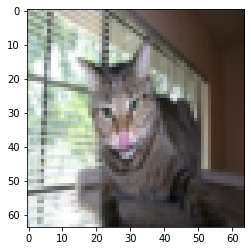

In [67]:
# 0이 noncat, 1이 cat
index = 20
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print(test_set_y[0, index])

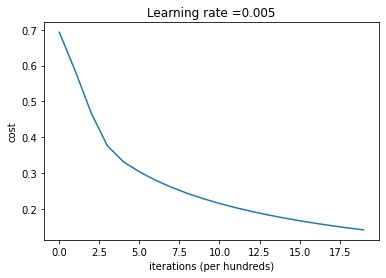

In [68]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



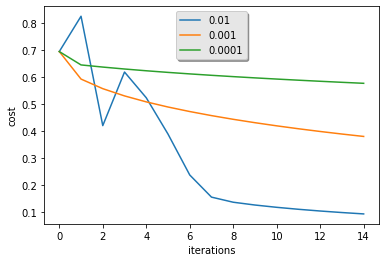

In [69]:
# learning rate 별 costs 

learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()